<a href="https://colab.research.google.com/github/ShreyBodra/Machine_Learning/blob/master/SentimentalAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentimental Analysis


In [ ]:
!pip install nltk
!pip install imblearn
!pip install tensorflow
!pip install keras

In [ ]:
# Data Preprocessing
import numpy as np
import pandas as pd
import re
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from scipy import stats
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import KFold

# Bidirectional LSTM (BiLSTM)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import load_model

# Naive Bayes
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

# XGBOOST
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV

# SVC
from sklearn.svm import SVC

# Downloading necessary NLTK resources
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Fetching Data

In [ ]:
# Read data from csv file
df = pd.read_csv('sample_data/text.csv')

In [ ]:
df.shape

(416809, 3)

### Emotion Analysis Twitter Dataset

This dataset contains text segments extracted from Twitter messages along with corresponding labels indicating the predominant emotion conveyed. The emotions are classified into six categories:

<br>

<center>


| Text Segment                                         | Emotion | Label    |
|------------------------------------------------------|---------|----------|
| This is a sad tweet.                                 | Sadness | 0        |
| Feeling so happy today!                              | Joy     | 1        |
| Love spending time with my family.                   | Love    | 2        |
| Can't believe how angry I am right now.             | Anger   | 3        |
| Scared to go out alone at night.                     | Fear    | 4        |
| Surprised by the news!                               | Surprise| 5        |

</center>


In [ ]:
# Rename the first column to "index"
df.rename(columns={df.columns[0]: 'index'}, inplace=True)

# Set the first column as the index
df.set_index('index', inplace=True)
df.head(10)

,text,label
index,,
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4
5,i was beginning to feel quite disheartened,0
6,i would think that whomever would be lucky eno...,2
7,i fear that they won t ever feel that deliciou...,1
8,im forever taking some time out to have a lie ...,5


# Data Preprocessing

In [ ]:
# Remove duplicates and null values
df.drop_duplicates(inplace=True) # 3% of the data contains duplicate values
df.dropna(how='all',inplace=True)

In [ ]:
# Handle chat words
chat_words = {
    "lol": "Laugh out loud",
    "brb": "Be right back",
    "ttyl": "Talk to you later",
    "omg": "Oh my god",
    "idk": "I don't know",
    "btw": "By the way",
    "thx": "Thanks",
    "np": "No problem",
    "imo": "In my opinion",
    "gtg": "Got to go",
    "lmao": "Laughing my ass off",
    "bff": "Best friends forever",
    "ily": "I love you",
    "hmu": "Hit me up",
    "rofl": "Rolling on the floor laughing",
    "tbh": "To be honest",
    "g2g": "Got to go",
    "yw": "You're welcome",
    "smh": "Shaking my head",
    "jk": "Just kidding",
    "gg": "Good game",
    "imho": "In my humble opinion",
    "nvm": "Never mind",
    "dw": "Don't worry",
    "wb": "Welcome back",
    "plz": "Please",
    "hbu": "How about you?",
    "idc": "I don't care",
    "atm": "At the moment",
    "fyi": "For your information",
    "ik": "I know",
    "cya": "See you later",
    "bae": "Before anyone else",
    "2moro": "Tomorrow",
    "cu": "See you",
    "gr8": "Great",
    "4eva": "Forever",
    "ilu": "I love you",
    "l8r": "Later",
    "irl": "In real life",
    "tgif": "Thank god it's Friday",
    "yolo": "You only live once",
    "omw": "On my way",
    "tmi": "Too much information",
    "bruh": "Brother/friend"
}
def replace_chat_words(text):
    words = text.split()
    for i, word in enumerate(words):
        if word.lower() in chat_words:
            words[i] = chat_words[word.lower()]
    return ' '.join(words)

df['text'] = df['text'].apply(replace_chat_words)

In [ ]:

# Remove non alpha numeric character and numbers
df['text'] = df['text'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x).replace(r'\d+', ''))

In [ ]:
# Remove urls
df['text'] = df['text'].str.replace(r'http\S+', '', regex=True)

In [ ]:
# Handle stop words
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

def remove_stopwords(text):
  word_tokens = word_tokenize(text)
  filtered_text = []
  for word in word_tokens:
    if not word.lower() in stop_words:
      word = lemmatizer.lemmatize(word)
      filtered_text.append(word)
  return " ".join(filtered_text)
print(df.head)
df['text'] = df['text'].apply(remove_stopwords)
df.head(10)


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


<bound method NDFrame.head of                                                      text  label
index                                                           
0           i just feel really helpless and heavy hearted      4
1       ive enjoyed being able to slouch about relax a...      0
2       i gave up my internship with the dmrg and am f...      4
3                              i dont know i feel so lost      0
4       i am a kindergarten teacher and i am thoroughl...      4
...                                                   ...    ...
416804  i feel like telling these horny devils to find...      2
416805  i began to realize that when i was feeling agi...      3
416806  i feel very curious be why previous early dawn...      5
416807  i feel that becuase of the tyranical nature of...      3
416808  i think that after i had spent some time inves...      5

[416123 rows x 2 columns]>


,text,label
index,,
0,feel really helpless heavy hearted,4
1,ive enjoyed able slouch relax unwind frankly n...,0
2,gave internship dmrg feeling distraught,4
3,dont know feel lost,0
4,kindergarten teacher thoroughly weary job take...,4
5,beginning feel quite disheartened,0
6,would think whomever would lucky enough stay s...,2
7,fear ever feel delicious excitement christmas ...,1
8,im forever taking time lie feel weird,5


# Data Visualization



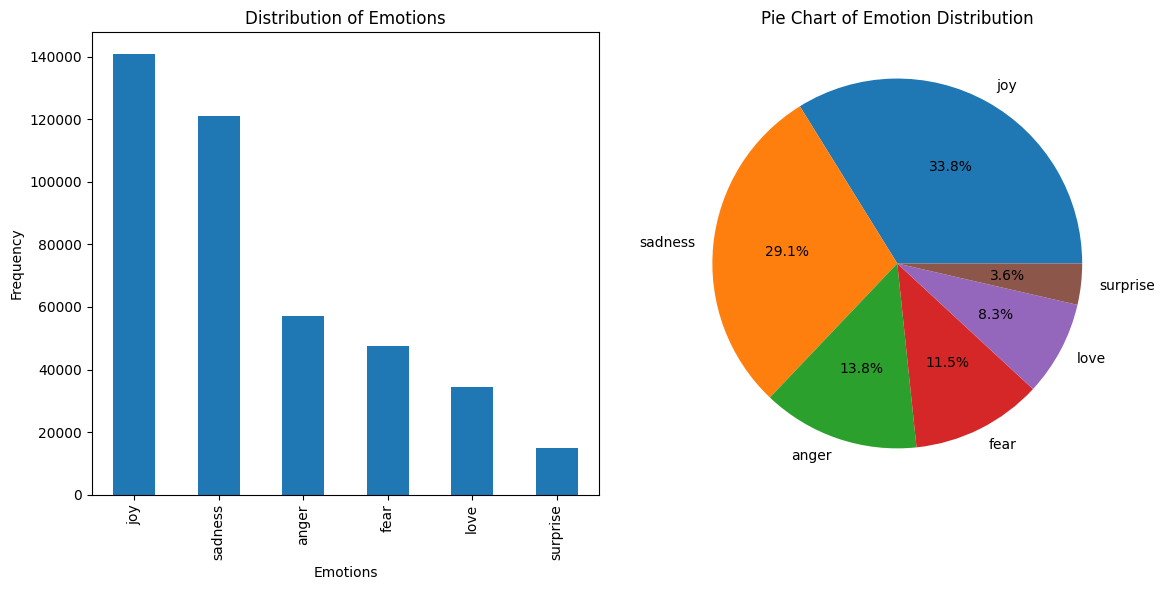

In [ ]:
# plotting class distribution
emotion_map = {
    0: 'sadness',
    1: 'joy',
    2: 'love',
    3: 'anger',
    4: 'fear',
    5: 'surprise'
}


# Replace numeric labels with emotions using the emotion_map dictionary
df['emotion'] = df['label'].map(emotion_map)

# Calculate emotion counts
emotion_counts = df['emotion'].value_counts()

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Bar plot
emotion_counts.plot(kind='bar', ax=axes[0])
axes[0].set_xlabel('Emotions')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Emotions')

# Pie chart
emotion_counts.plot(kind='pie', autopct='%1.1f%%', ax=axes[1])
axes[1].set_title('Pie Chart of Emotion Distribution')
axes[1].set_ylabel('')  # This removes the 'emotion' ylabel which is unnecessary for a pie chart

plt.tight_layout()
plt.show()


# Splitting data into training and testing

In [ ]:
# vectorization
vectorizer = TfidfVectorizer(max_features=10000)
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.3, random_state=42, stratify=df['label'])

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# tokenizer
tokenizer = Tokenizer(num_words = 60000)
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)


# Maximum Length in X_train_sequences
maxlen = max(len(tokens) for tokens in X_train_sequences)
print("Maximum sequence length (maxlen):", maxlen)

# Perform padding on X_train and X_test sequences
X_train_padded = pad_sequences(X_train_sequences, maxlen=maxlen, padding='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=maxlen, padding='post')

# Embedding input size
input_dim = np.max(X_train_padded)
print(input_dim)

Maximum sequence length (maxlen): 79
58108





# Model

## BiLSTM

In [ ]:
def BiLSTM(X_train, y_train, X_test, y_test, model_save_path):
    if os.path.exists(model_save_path):
        # Load pre-trained model
        model = load_model(model_save_path)
        print("Pre-trained model loaded successfully.")
    else:
        # Define model
        model = Sequential()

        model.add(Embedding(input_dim=input_dim, output_dim=100, input_shape=(79,)))

        # Add a bidirectional LSTM layer with 256 units
        model.add(Bidirectional(LSTM(256)))

        # Add batch normalization layer
        model.add(BatchNormalization())

        # Add dropout regularization
        model.add(Dropout(0.5))

        # Add a dense layer with 128 units and ReLU activation
        model.add(Dense(128, activation='relu'))

        # Add dropout regularization
        model.add(Dropout(0.5))

        # Add the output layer with 6 units for 6 labels and softmax activation
        model.add(Dense(6, activation='softmax'))

        # Compile the model
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        print("New model created.")

    # Define early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Define checkpoint to save the model after every epoch
    checkpoint = ModelCheckpoint(model_save_path, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

    # Train the model with early stopping
    model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.3, callbacks=[checkpoint, early_stopping])

    # Make predictions for testing set
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Calculate metrics
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(conf_matrix)

    # Print classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

BiLSTM(X_train_padded, y_train, X_test_padded, y_test, 'my_model.h5')

New model created.
Epoch 1/100
3184/3186 [============================>.] - ETA: 0s - loss: 0.2995 - accuracy: 0.8810
Epoch 1: saving model to my_model.h5
3186/3186 [==============================] - 89s 27ms/step - loss: 0.2994 - accuracy: 0.8810 - val_loss: 0.1596 - val_accuracy: 0.9192


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/100
3185/3186 [============================>.] - ETA: 0s - loss: 0.1280 - accuracy: 0.9320
Epoch 2: saving model to my_model.h5
3186/3186 [==============================] - 67s 21ms/step - loss: 0.1280 - accuracy: 0.9320 - val_loss: 0.1761 - val_accuracy: 0.9293
Epoch 3/100
3183/3186 [============================>.] - ETA: 0s - loss: 0.1050 - accuracy: 0.9391
Epoch 3: saving model to my_model.h5
3186/3186 [==============================] - 68s 21ms/step - loss: 0.1050 - accuracy: 0.9391 - val_loss: 0.1101 - val_accuracy: 0.9361
Epoch 4/100
3186/3186 [==============================] - ETA: 0s - loss: 0.0965 - accuracy: 0.9411
Epoch 4: saving model to my_model.h5
3186/3186 [==============================] - 65s 20ms/step - loss: 0.0965 - accuracy: 0.9411 - val_loss: 0.1014 - val_accuracy: 0.9362
Epoch 5/100
3185/3186 [============================>.] - ETA: 0s - loss: 0.0915 - accuracy: 0.9430
Epoch 5: saving model to my_model.h5
3186/3186 [==============================] - 65s 20